In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


import warnings
warnings.filterwarnings("ignore")

In [2]:
FI = 500 # mm
TW = 20 # mm
H = 55 # m
M = 1500 # kg
q = 1.5
ag = 0.63
tvary = 3
hmoty = 4

Lokalita - Bratislava\
Podlozie - C\
Spektrum - 2

In [3]:
delta11 = 0.30367329
delta12 = 0.19217220
delta13 = 0.09490424
delta14 = 0.02610248

delta21 = 0.19217220
delta22 = 0.12812319
delta23 = 0.06643804
delta24 = 0.01898592

delta31 = 0.09490424
delta32 = 0.06643804
delta33 = 0.03797184
delta34 = 0.01186937

delta41 = 0.02610248
delta42 = 0.01898592
delta43 = 0.01186937
delta44 = 0.00475282

In [5]:
def matica_hmotnosti(m):
    return np.diag([m, m, m, m])

In [6]:
mm = matica_hmotnosti(M)

In [7]:
delta = np.array([
    [delta11, delta12, delta13, delta14],
    [delta21, delta22, delta23, delta24],
    [delta31, delta32, delta33, delta34],
    [delta41, delta42, delta43, delta44]])
delta

array([[0.30367329, 0.1921722 , 0.09490424, 0.02610248],
       [0.1921722 , 0.12812319, 0.06643804, 0.01898592],
       [0.09490424, 0.06643804, 0.03797184, 0.01186937],
       [0.02610248, 0.01898592, 0.01186937, 0.00475282]])

In [8]:
def H_vector(H):
    H_vect =  np.array([H, 3*H/4, 2*H/4, H/4, 0])
    return H_vect

In [9]:
def plotSchema(delta, ax, index):
    i = index
    delta = np.insert(delta, 4, 0, axis=1)
    X = delta[i]
    Y = H_vector(H)

    ax.plot(X, Y, 'o-', color='gray')
    # plt.axis('off')
    el = mpatches.Circle((X[i], Y[i]), radius=2, alpha=0.5) # deformated circle because of difference in scaling of x axis
    ax.add_artist(el)

    ax.margins(0.5, 0.2)
    ax.title.set_text(f"{hmoty-i+1}. bod")
    
    for xy in zip(X, Y):         
        ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

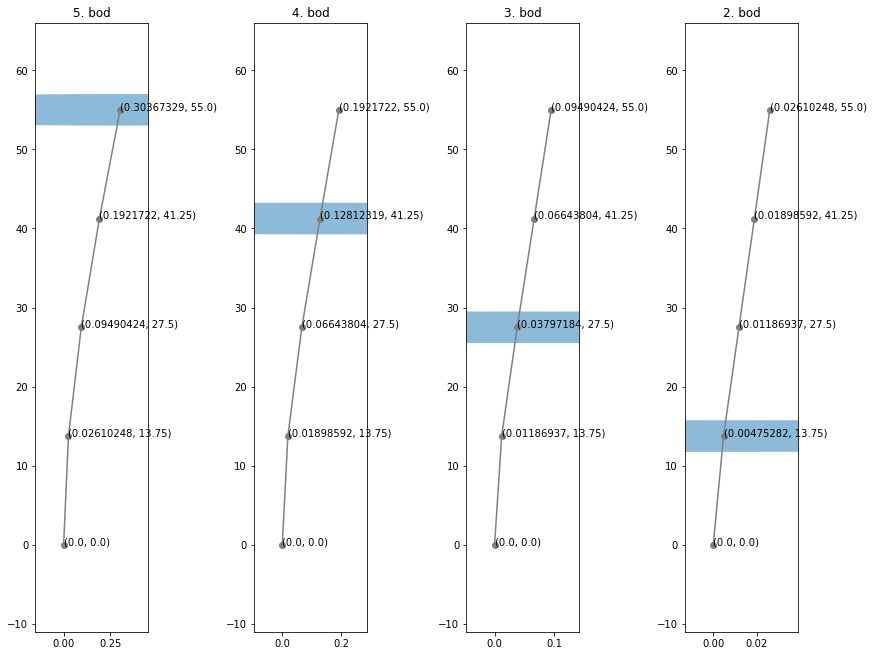

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4, constrained_layout=True, figsize=(12, 9))

i = 0
for ax in axs.flat:
    i += 1
    plotSchema(delta, ax, i-1)

In [12]:
def delta_inv(delta):
    return np.linalg.inv(delta)

In [13]:
def frekvencie(delta_inv, mm):
    eigvals = np.linalg.eig(delta_inv)[0]
    reoder = [eigvals[2], eigvals[3], eigvals[1], eigvals[0]]
    L = np.diag(reoder)

    omega = np.nan_to_num(np.sqrt(L/mm))
    f = np.diag(np.sqrt(L/(mm*10**-3)))/(2*np.pi)

    print(f'frekvencia 1. tvaru: {f[0]:.3f} Hz \n frekvencia 2. tvaru: {f[1]:.3f} Hz \n frekvencia 3. tvaru: {f[2]:.3f} Hz')
    return f, omega

In [14]:
f, omega = frekvencie(delta_inv(delta), mm)

frekvencia 1. tvaru: 0.191 Hz 
 frekvencia 2. tvaru: 1.232 Hz 
 frekvencia 3. tvaru: 3.475 Hz


In [15]:
def periody(frekvencie):
    T = 1/frekvencie
    T = np.delete(T, -1)
    print(f'perioda 1. tvaru: {T[0]:.3f} s \n perioda 2. tvaru: {T[1]:.3f} s \n perioda 3. tvaru: {T[2]:.3f} s')
    return T

In [16]:
T = periody(f)

perioda 1. tvaru: 5.228 s 
 perioda 2. tvaru: 0.812 s 
 perioda 3. tvaru: 0.288 s


In [17]:
def vlastny_tvar(hmoty, tvary, omega, delta_inv, iteracia):
    i = iteracia

    V0k = np.zeros((hmoty, tvary))

    # diag matrix of hmoty * omega
    p4 = np.eye(hmoty) * omega[i, i]
    # print(f'p4 \n {p4}')
    p5 = delta_inv - mm * p4**2
    # print(f'p5 \n {p5}') 

    # drop first row and first column
    A = p5[1:hmoty, 1:hmoty]
    # get first column and drop first row
    B = p5[1:hmoty, 0:1]

    # solve linear equation
    S = np.linalg.solve(A, B)*-1 # -1 lebo som prehodil posledny stlpec na druhu stranu rovnice
    S = np.insert(S,0,1)
    # print(f'S \n {S}')

    # insert S to V0k
    V0k[:, i] = S

    # dot product of V0k transposed, mm and V0k
    q0 = 1/np.sqrt(np.dot(np.dot(V0k.T, mm),V0k))[i,i]
    # print(f'q0 = {q0}')

    # insert q0 to V0
    V0 = q0*S*10**3
    print(f'{i+1}. vlastny tvar V0 = {V0}')
    
    return V0

In [20]:
def vlastne_tvary(tvary, hmoty, omega, delta):
    V0 = []
    for i in range(tvary):
        vlTvar = vlastny_tvar(hmoty, tvary, omega, delta_inv(delta), i)
        V0.append(vlTvar)
    V0 = np.array(V0)
    return V0

In [22]:
V0 = vlastne_tvary(tvary, hmoty, omega, delta)

1. vlastny tvar V0 = [20.84136981 13.48402444  6.83842055  1.92900506]
2. vlastny tvar V0 = [ 13.01129449  -9.73397569 -17.90720069  -9.052887  ]
3. vlastny tvar V0 = [  7.36935085 -16.77362131   5.7453293   17.26256511]


spektrum pruznej odozvy

In [23]:
def spektrum_parametre_2(podlozie):
    if podlozie == "A":
        S = 1
        T_B = 0.05
        T_C = 0.25
        T_D = 1.2

    if podlozie == "B":
        S = 1.35
        T_B = 0.05
        T_C = 0.25
        T_D = 1.2
    
    if podlozie == "C":
        S = 1.5
        T_B = 0.1
        T_C = 0.25
        T_D = 1.2

    if podlozie == "D":
        S = 1.8
        T_B = 0.1
        T_C = 0.3
        T_D = 1.2

    if podlozie == "E":
        S = 1.6
        T_B = 0.05
        T_C = 0.25
        T_D = 1.2

    parametre_podlozia = {
        "S" : S,
        "T_B": T_B,
        "T_C": T_C,
        "T_D": T_D,
    }

    return parametre_podlozia


In [24]:
def sd(parametre, T0, ag, q):
    # navrhove spektrum sd
    S = parametre["S"]
    T_B = parametre["T_B"]
    T_C = parametre["T_C"]
    T_D = parametre["T_D"]

    beta = 0.2 # narodna priloha smie stanovit hodnotu beta. Doporucena hodnota je 0.2

    if 0 <= T0 < T_B:
        sd = ag*S*(2/3+T0/T_B*(2.5/q-2/3))
    elif T_B <= T0 < T_C:
        sd = ag*S*(2.5/q)
    elif T_C <= T0 < T_D:
        sd = ag*S*2.5/q*(T_C/T0)
        if sd < ag*beta:
            sd = ag*beta
    elif T_D <= T0:
        sd = ag*S*2.5/q*(T_C*T_D/T0**2)
        if sd < ag*beta:
            sd = ag*beta
    return sd    


### Navrhove spektrum

In [25]:
def spektrum(ag, q, periody):
    Sd = []
    for perioda in periody:
        Sd.append(sd(spektrum_parametre_2("C"), perioda, ag, q))
    print(f'Sd = {Sd}')
    return Sd

In [26]:
Sd = spektrum(ag, q, T)

Sd = [0.126, 0.48501428897161153, 1.3684345749124756]


### Metoda nahradnych seizmickych sil

In [27]:
def hmoty_total(M, hmoty):
    return M*hmoty

In [28]:
def Fb(hmoty_total, sd, lambda_):
    Fb =  hmoty_total*lambda_*sd
    print(f"Fb = {Fb} kN")
    return Fb

In [29]:
Fb_ = Fb(hmoty_total(M, hmoty), Sd[0], lambda_=1)

Fb = 756.0 kN


In [30]:
def seizmicke_sily(V0, M, Fb_, hmoty):
    F = []
    for i in range(hmoty):
        V01 = V0[0].sum()
        V01 = V01 - V0[0][i]
        FF = Fb_*(V0[0][i]*M)/(V01*3*M)
        F.append(FF)
    print(f'F [kN] = {F}')
    return F


In [31]:
F = seizmicke_sily(V0, M, Fb_, hmoty)

F [kN] = [236.0306936824867, 114.76232353951663, 47.53304458373295, 11.809140565926725]


In [32]:
HV = np.delete(H_vector(H), -1).reshape(4,1) # remove 0 height and reshape to 4x1 matrix
F = np.array(F).reshape((4, 1)) 

vysledne momenty

In [33]:
def moment_FxR(F, HV):
    M = HV * F
    print(f'Momenty [kNm]\n {M}')
    return M

In [34]:
mom = moment_FxR(F, HV)

Momenty [kNm]
 [[12981.68815254]
 [ 4733.94584601]
 [ 1307.15872605]
 [  162.37568278]]


Viactvarovy vypocet

In [35]:
def gama(V0, mm):
    m = np.array([np.diag(mm)])
    gama = np.dot(V0, m.T*10**-3)
    print(f'Sucinitel participacie gama \n {gama}')
    return gama

In [36]:
gama_ = gama(V0, mm)

Sucinitel participacie gama 
 [[ 64.63922979]
 [-35.52415333]
 [ 20.40543593]]


In [37]:
def zrychlenie_i(Sd, gama, V0, riadky=0, stlpce=0):
    i = riadky
    j = stlpce
    X =  Sd[j]*gama[j, 0]*V0[j,i]
    return X  

In [38]:
def zrychlenie_tot(hmoty, tvary, Sd, V0):
    stlpce = []
    for j in range(tvary):
        riadky = []
        stlpce.append(riadky)
    
        for i in range(hmoty):
            riadky.append(zrychlenie_i(Sd, gama_, V0, riadky=i, stlpce=j))
    A = np.array(stlpce)
    print(f'zrychlenia \n {A}')
    return A

In [39]:
def sily_zrychlenia(zrychlenia, M):
    F = M*zrychlenia*10**-3
    print(f'Vysledne sily \n {F}')
    return F

In [40]:
FF = sily_zrychlenia(zrychlenie_tot(hmoty, tvary, Sd, V0), M)

zrychlenia 
 [[ 169.74343159  109.82121624   55.6958099    15.71086457]
 [-224.18098654  167.71369477  308.5360892   155.97872598]
 [ 205.77809821 -468.37828241  160.429726    482.03130672]]
Vysledne sily 
 [[ 254.61514738  164.73182436   83.54371485   23.56629685]
 [-336.2714798   251.57054215  462.80413379  233.96808896]
 [ 308.66714731 -702.56742361  240.644589    723.04696008]]


In [41]:
def moment(Sd, gama, V0, H_vector, riadky=0, stlpce=0):
    i = riadky
    j = stlpce
    X =  Sd[j]*gama[j, 0]*V0[j,i]*H_vector[j, 0]
    return X 

In [42]:
def moment_tot(hmoty, tvary, Sd, gama_, V0, HV):
    stlpce = []
    for j in range(tvary):
        riadky = []
        stlpce.append(riadky)
        for i in range(hmoty):
            riadky.append(moment(Sd, gama_, V0, HV, riadky=i, stlpce=j))
    momenty = np.array(stlpce)
    print(f'momenty \n {momenty}')
    return momenty
    

In [43]:
MM = moment_tot(hmoty, tvary, Sd, gama_, V0, HV)

momenty 
 [[  9335.88873726   6040.16689332   3063.26954461    864.09755133]
 [ -9247.46569458   6918.18990908  12727.11367935   6434.12244648]
 [  5658.8977007  -12880.40276616   4411.81746506  13255.86093476]]
